<a href="https://colab.research.google.com/github/PeroumalPajany/tmp/blob/main/PajanyPTIM8131_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💡  **Overview**

Experimental Study to forecast stock prices for "Exploring and Assessing Data Mining Techniques for Complex Data Types."

Peroumal Pajany  
May 26, 2024


In [24]:
!pip install -q pmdarima yfinance


## 👉Libraries



In [25]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import pmdarima as pm
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


## 👉 Configure Parameters

In [26]:
stock_years = 10
sel_company = 'MSFT'
training_size = 0.9

end = datetime.now()
start = datetime(end.year - stock_years, end.month, end.day)



## 👉 Top Tech Company Stocks

In [27]:

companies = ['AAPL', 'META', 'GOOG', 'MSFT', 'AMZN', 'NVDA']

for stock in companies:
    globals()[stock] = yf.download(stock, start, end)
company_list = [AAPL, META, GOOG, MSFT, AMZN, NVDA]
company_name = ['Apple', 'Meta', 'Alphabet', 'Microsoft', 'Amazon', 'Nvidia']
for company, name in zip(company_list, company_name):
    company["company_name"] = name

data = pd.concat(company_list, axis=0)
display(data.head(2))
display(data.tail(2))

print(f'\nTotal record downloaded = {len(data)}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2014-05-27,21.995714,22.352142,21.986786,22.343929,19.763992,348866000,Apple
2014-05-28,22.357857,22.493929,22.277857,22.286072,19.712812,315481600,Apple


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-05-23,1020.280029,1063.199951,1015.200012,1037.989990,1037.989990,83309000,Nvidia
2024-05-24,1045.180054,1049.910034,1030.000000,1046.310059,1046.310059,22888586,Nvidia



Total record downloaded = 15108


## 👉 Top Tech Company Stock Analysis

In [28]:
# Summary Stats
META.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,193.874821,196.370258,191.488948,193.994996,193.803087,2.427731e+07
std,95.229954,96.495241,94.011911,95.276192,95.217383,1.542833e+07
min,61.619999,63.340000,61.570000,62.500000,62.433758,5.467500e+06
25%,122.000000,123.827497,120.522501,121.977499,121.848219,1.526518e+07
50%,175.619995,177.855003,173.280006,175.754997,175.568718,2.026660e+07
75%,248.754993,253.377506,246.639996,249.187504,248.923397,2.830565e+07
max,529.280029,531.489990,518.890015,527.340027,527.340027,2.323166e+08


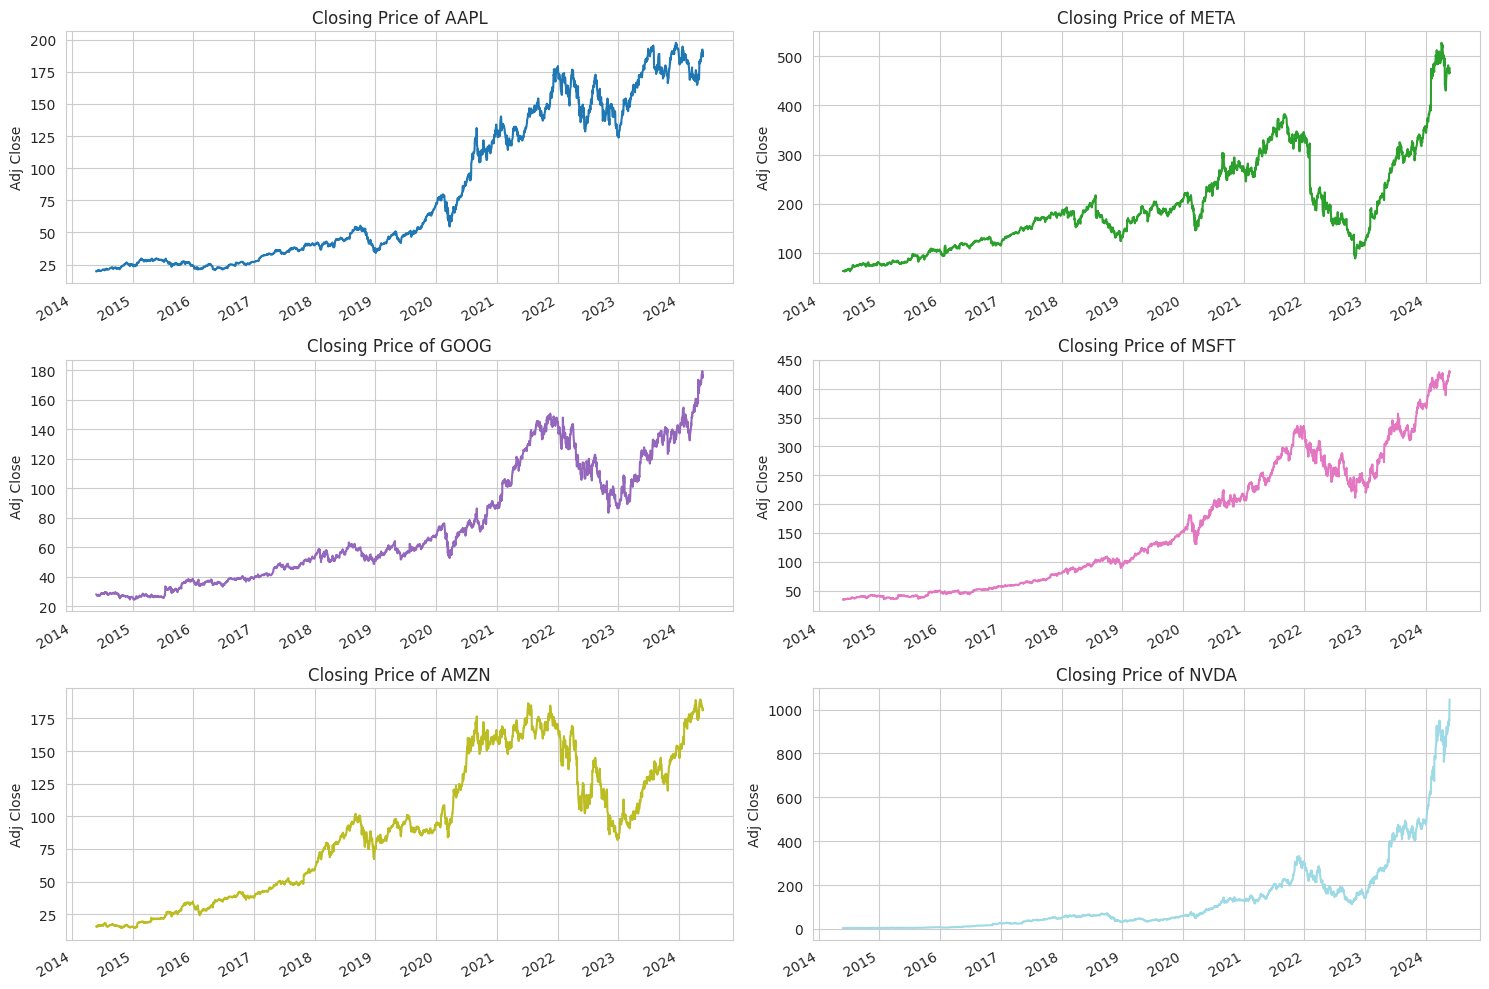

In [29]:
colors = plt.cm.tab20(np.linspace(0, 1, len(company_list)))

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, (company, color) in enumerate(zip(company_list, colors), 1):
    plt.subplot(3, 2, i)
    company['Adj Close'].plot(color=color)
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {companies[i - 1]}")

plt.tight_layout()
plt.show()


In [30]:
df = yf.download(sel_company, start, end)
display(df.tail(3))

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-22,430.089996,432.410004,427.130005,430.519989,430.519989,18073700
2024-05-23,432.970001,433.600006,425.420013,427.000000,427.000000,17190100
2024-05-24,427.209991,430.332092,424.410004,429.822205,429.822205,5440469


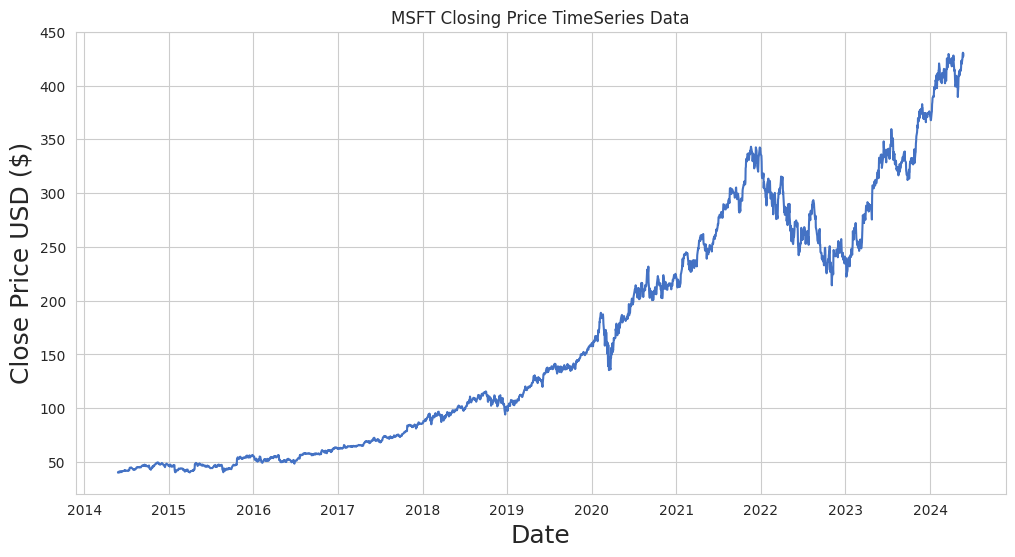

In [31]:
plt.figure(figsize=(12,6))
plt.title(f'{sel_company} Closing Price TimeSeries Data')
plt.plot(df['Close'], color='#4472C4')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().patch.set_alpha(0)
plt.show()

## 👉 Preprocessing

In [32]:
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [33]:
train_size = int(len(scaled_data) * training_size)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [34]:
def create_data_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_data_sequences(train_data, seq_length)
X_test, y_test = create_data_sequences(test_data, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 👉TimeSeries Models

### 📍 *LSTM*

In [35]:

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

Epoch 1/20
69/69 [==============================] - 12s 44ms/step - loss: 0.0074 - val_loss: 0.0012
Epoch 2/20
69/69 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/20
69/69 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 4/20
69/69 [==============================] - 2s 23ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 6/20
69/69 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/20
69/69 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/20
69/69 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 9/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/20
69/69 [==============================] - 1s 10ms/step - loss: 9.2646e-04 - val_loss: 0.0018
Epoch

In [36]:

last_sequence = scaled_data[-seq_length:]
future_predictions = []

for _ in range(10):
    next_pred = lstm_model.predict(last_sequence.reshape(1, seq_length, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = [end + pd.Timedelta(days=i) for i in range(1, 11)]
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted Close'])

future_df.index = pd.to_datetime(future_df.index).date

display(future_df)

1/1 [==============================] - 0s 21ms/step


,Predicted Close
2024-05-25,416.269073
2024-05-26,416.484192
2024-05-27,416.032135
2024-05-28,415.147491
2024-05-29,413.991821
2024-05-30,412.672852
2024-05-31,411.261444
2024-06-01,409.803253
2024-06-02,408.327515
2024-06-03,406.852264


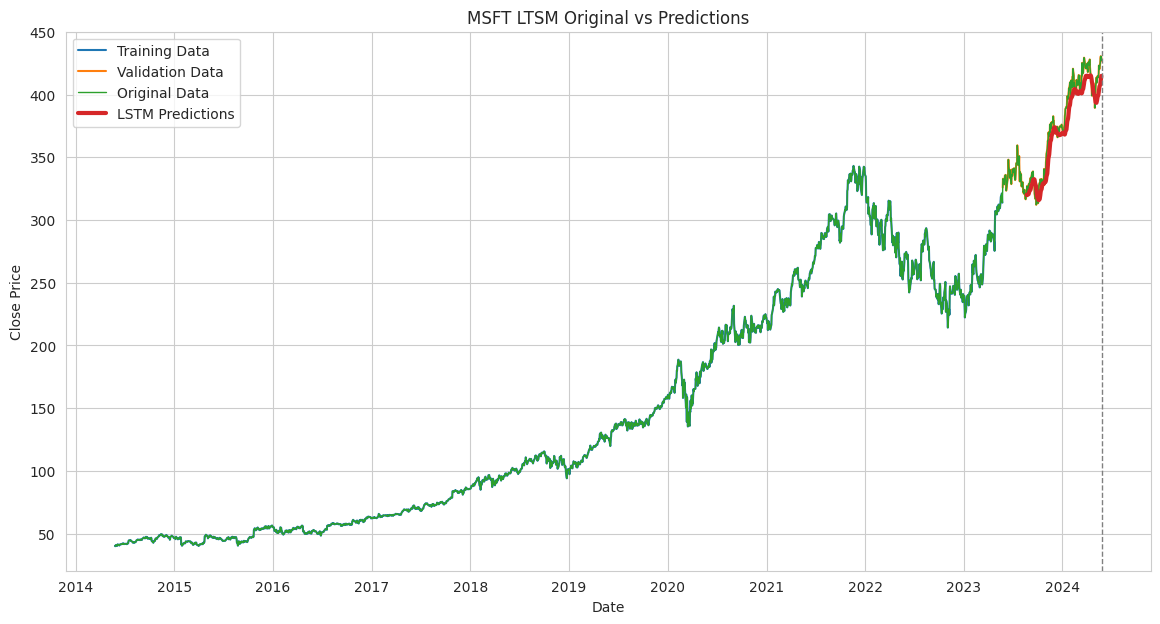

In [37]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[:train_size], df['Close'][:train_size], label='Training Data')
plt.plot(df.index[train_size:], df['Close'][train_size:], label='Validation Data')
plt.plot(df['Close'], label='Original Data', linestyle='-', linewidth=1)

plt.plot(df.index[train_size + seq_length:], lstm_predictions, label='LSTM Predictions', linestyle='-', linewidth=3)

plt.axvline(x=datetime.now(), color='grey', linestyle='--', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{sel_company} LSTM Original vs Predictions')
plt.legend()
plt.show()

### 📍 *Prophet*

In [38]:
df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpua7xa1oh/e8r8zqw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpua7xa1oh/5on8ciu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2393', 'data', 'file=/tmp/tmpua7xa1oh/e8r8zqw4.json', 'init=/tmp/tmpua7xa1oh/5on8ciu8.json', 'output', 'file=/tmp/tmpua7xa1oh/prophet_model05xc71jk/prophet_model-20240524163856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
from datetime import datetime, timedelta
forecast_next_10_days = forecast[(forecast['ds'] > end) & (forecast['ds'] <= end + timedelta(days=10))][['ds', 'yhat']]
forecast_next_10_days.rename(columns={'ds': 'Date', 'yhat': 'Predicted Close'}, inplace=True)

forecast_next_10_days.set_index('Date', inplace=True)
display(forecast_next_10_days)

,Predicted Close
Date,
2024-05-25,411.274635
2024-05-26,411.510539
2024-05-27,411.943451
2024-05-28,412.062049
2024-05-29,412.428592
2024-05-30,412.693262
2024-05-31,412.972288
2024-06-01,412.750200
2024-06-02,412.938022


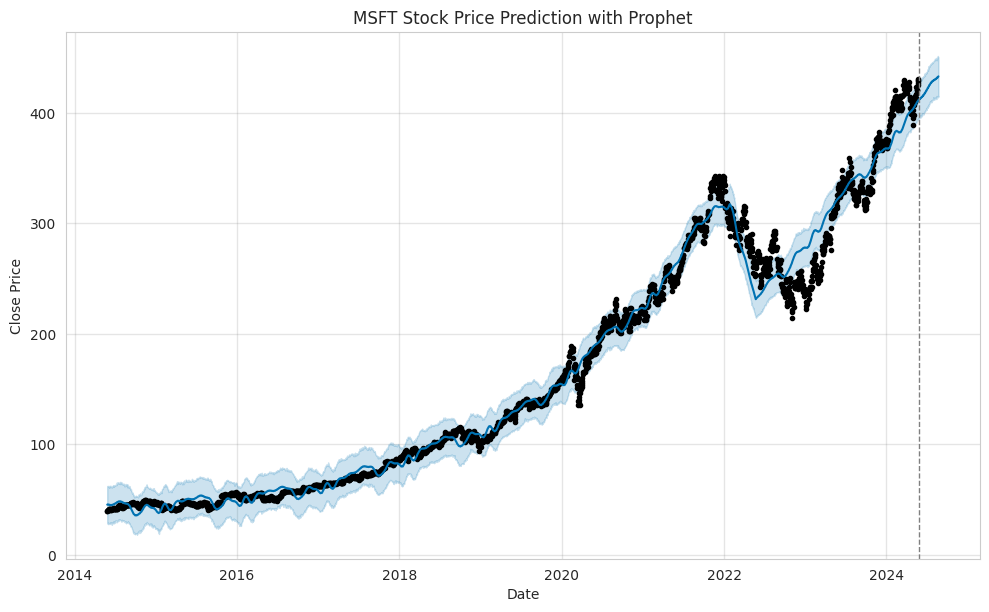

In [40]:
fig = prophet_model.plot(forecast)
plt.axvline(x=datetime.now(), color='grey', linestyle='--', linewidth=1)
plt.title(f'{sel_company} Stock Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


### 📍 *Arima*

In [41]:
arima_model = pm.auto_arima(df['Close'], seasonal=False, trace=True)

n_periods = 90
arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
arima_forecast_index = pd.date_range(start=df.index[-1], periods=n_periods + 1, freq='B')[1:]


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13185.095, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13209.627, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13185.346, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13182.948, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13213.045, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13181.102, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13183.051, Time=1.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13183.059, Time=3.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13181.394, Time=1.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13182.268, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13186.739, Time=0.64 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.953 seconds


### 📍 *XGB*

In [42]:
X_train_xgb = np.array([train_data[i:i + seq_length].flatten() for i in range(len(train_data) - seq_length)])
y_train_xgb = np.array([train_data[i + seq_length] for i in range(len(train_data) - seq_length)]).flatten()
X_test_xgb = np.array([test_data[i:i + seq_length].flatten() for i in range(len(test_data) - seq_length)])
y_test_xgb = np.array([test_data[i + seq_length] for i in range(len(test_data) - seq_length)]).flatten()

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train_xgb, y_train_xgb)
xgb_predictions = xgb_model.predict(X_test_xgb)
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))

In [43]:
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    return mse, rmse, mae, r2

## 👉 Plot Graph

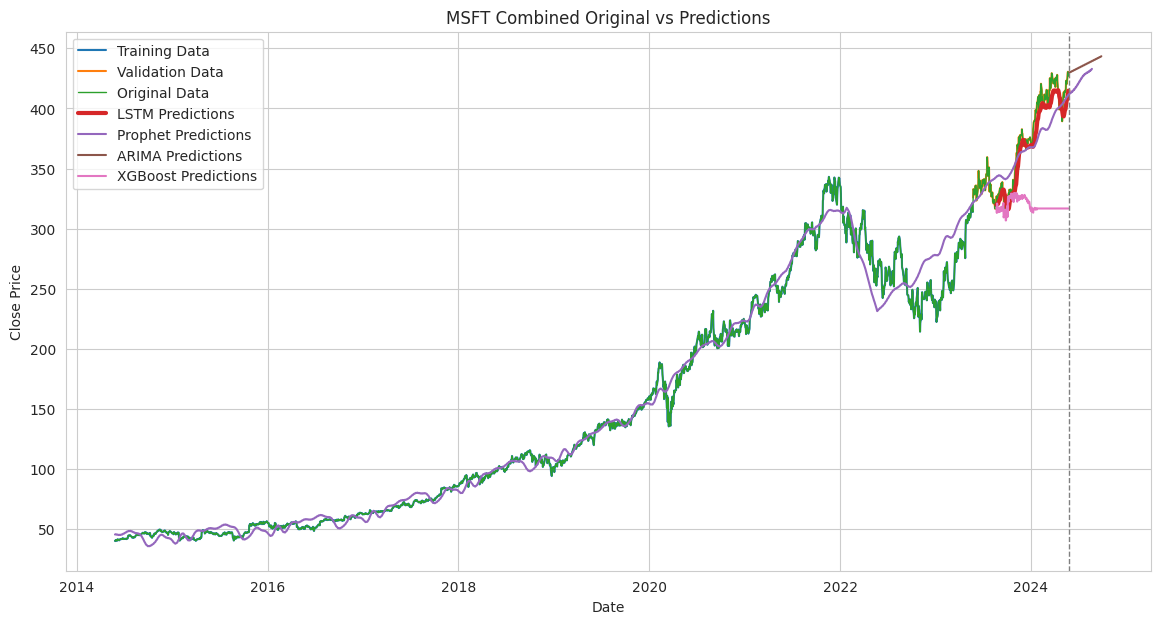

In [44]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[:train_size], df['Close'][:train_size], label='Training Data')
plt.plot(df.index[train_size:], df['Close'][train_size:], label='Validation Data')
plt.plot(df['Close'], label='Original Data', linestyle='-', linewidth=1)

plt.plot(df.index[train_size + seq_length:], lstm_predictions, label='LSTM Predictions', linestyle='-', linewidth=3)
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predictions')
plt.plot(arima_forecast_index, arima_forecast, label='ARIMA Predictions')
plt.plot(df.index[train_size + seq_length:], xgb_predictions, label='XGBoost Predictions')

plt.axvline(x=datetime.now(), color='grey', linestyle='--', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{sel_company} Combined Original vs Predictions')
plt.legend()
plt.show()

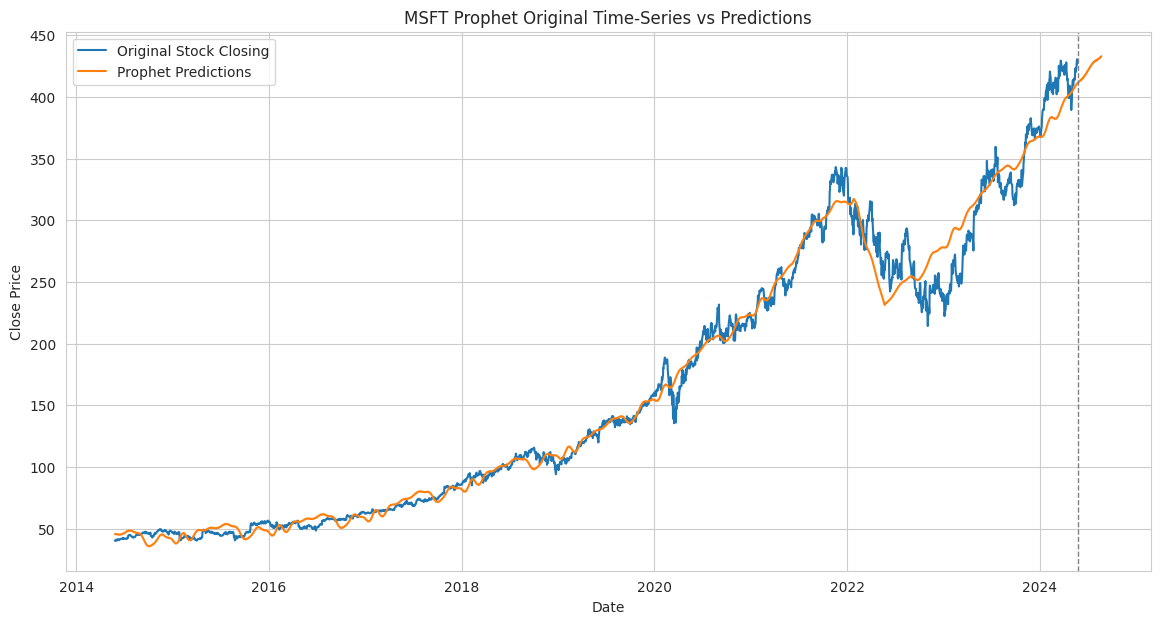

In [45]:
plt.figure(figsize=(14, 7))


plt.plot(df['Close'], label='Original Stock Closing')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predictions')
plt.axvline(x=datetime.now(), color='grey', linestyle='--', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{sel_company} Prophet Original Time-Series vs Predictions')
plt.legend()
plt.show()

## 👉 Calculate Metrics

Model,LSTM,Prophet,ARIMA,XGBoost
MSE,115.904832,194.651906,663.056465,5046.690703
MAE,9.015366,10.872864,24.150295,60.324353


,Model,MSE,MAE
0,LSTM,115.904832,9.015366
1,Prophet,194.651906,10.872864
2,ARIMA,663.056465,24.150295
3,XGBoost,5046.690703,60.324353


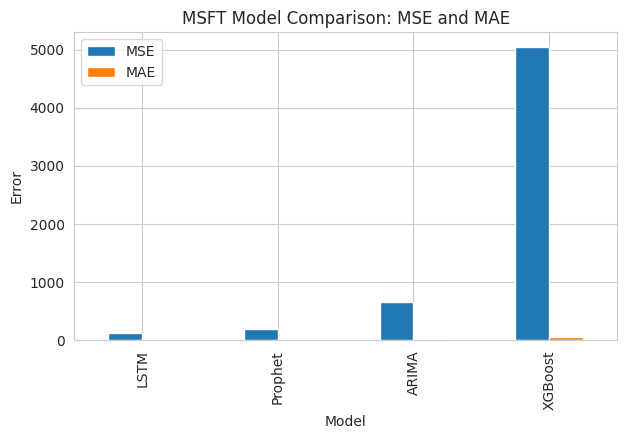

In [47]:
lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = calculate_metrics(df['Close'][train_size + seq_length:], lstm_predictions)
prophet_mse,prophet_rmse,prophet_mae, prophet_r2 = calculate_metrics(df['Close'][-n_periods:], forecast['yhat'][-n_periods:])
arima_mse, arima_rmse, arima_mae, arima_r2 = calculate_metrics(df['Close'][-n_periods:], arima_forecast)
xgb_mse, xgb_rmse, xgb_mae, xgb_r2 = calculate_metrics(df['Close'][train_size + seq_length:], xgb_predictions)

metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'Prophet', 'ARIMA', 'XGBoost'],
    'MSE': [lstm_mse, prophet_mse, arima_mse, xgb_mse],
    'MAE': [lstm_mae, prophet_mae, arima_mae, xgb_mae]

})

flip_df = metrics_df.transpose()
flip_df.columns = flip_df.iloc[0]
flip_df = flip_df[1:]

display(flip_df)


display(metrics_df )

metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(7, 4))
plt.title(f'{sel_company} Model Comparison: MSE and MAE')
plt.ylabel('Error')
plt.show()